In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

In [3]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)



labels_train = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=train_sampler, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32,shuffle=False, collate_fn=vital_pre_train)

train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30_datasampler"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [5]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.3358
[VAE Pretrain] Epoch 50/300 Avg ELBO: -381.4352 (Recon: -382.7709, KLw: 1.3358)
[Epoch 100] KL weight: 0.0041, KL: 2.9298
[VAE Pretrain] Epoch 100/300 Avg ELBO: -432.9735 (Recon: -435.9033, KLw: 2.9298)
[Epoch 150] KL weight: 0.0062, KL: 4.4278
[VAE Pretrain] Epoch 150/300 Avg ELBO: -455.6341 (Recon: -460.0619, KLw: 4.4278)
[Epoch 200] KL weight: 0.0083, KL: 6.0583
[VAE Pretrain] Epoch 200/300 Avg ELBO: -503.2629 (Recon: -509.3212, KLw: 6.0583)
[Epoch 250] KL weight: 0.0100, KL: 7.3299
[VAE Pretrain] Epoch 250/300 Avg ELBO: -509.9264 (Recon: -517.2563, KLw: 7.3299)
[Epoch 300] KL weight: 0.0100, KL: 7.4793
[VAE Pretrain] Epoch 300/300 Avg ELBO: -539.7333 (Recon: -547.2127, KLw: 7.4793)


In [6]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [7]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")
model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0151
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0149
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0149
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0138
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0138
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0137
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0136
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0136
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0136


In [8]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 200, beta= 150,
                                patience = 20)


[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


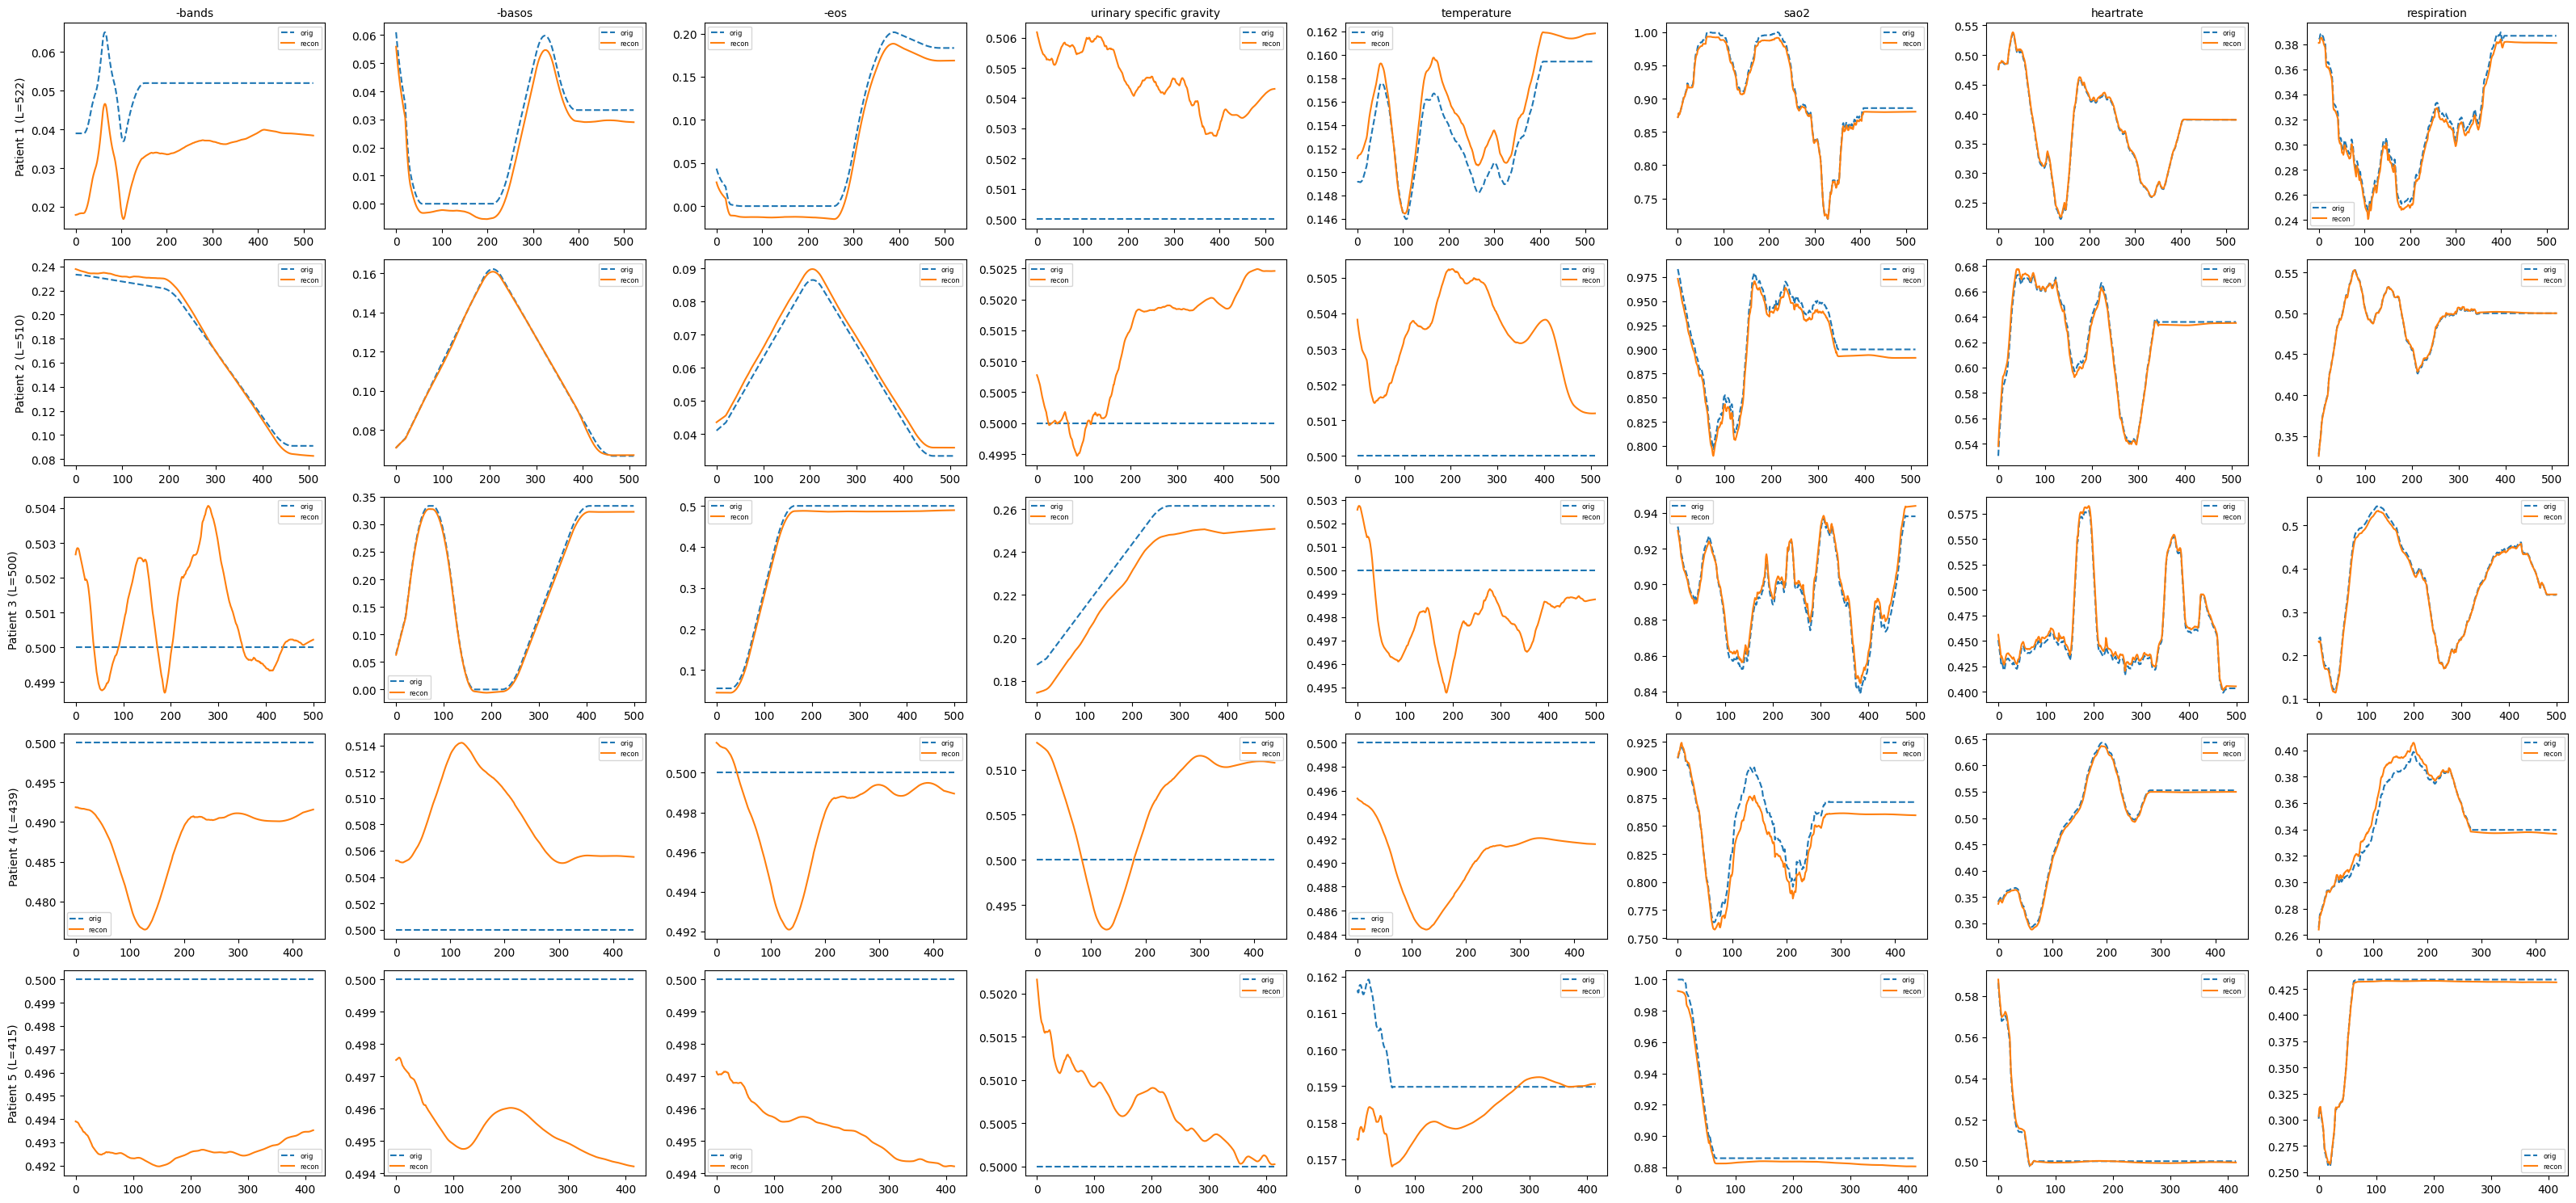

In [9]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 155267 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0110
  Std (overall): 0.2327
  Per-dim mean:
tensor([ 3.8251e-03,  2.1560e-02, -1.1901e-02, -2.0971e-02, -2.6821e-03,
         1.5394e-03, -3.7513e-03,  4.0096e-02, -7.1113e-04, -8.0405e-03,
         1.0051e+00, -1.5491e-02,  7.9153e-03,  2.7474e-02,  1.8818e-02,
         1.1407e-02, -2.6363e-02, -1.9056e-02,  6.6513e-03, -4.9979e-03,
        -1.7764e-02, -6.2173e-05, -5.8645e-03,  6.7094e-03,  1.0674e+00,
         1.3228e-02, -8.3509e-03, -6.8864e-03, -9.3647e-03, -1.1713e-03,
         2.8931e-02, -5.3866e-03,  1.4942e-03, -9.8821e-04,  1.7679e-02,
         8.3565e-01, -2.0025e-02,  6.3535e-03, -1.8653e-02,  1.3506e-02,
        -1.4125e-03,  4.8427e-03, -2.4053e-01, -7.2509e-03, -2.2196e-02,
         1.7040e-04, -9.7557e-03, -2.2786e-02,  1.7170e-03,  5.2270e-03,
         5.0276e-03, -2.5778e-02,  1.0978e-02,  1.9661e-02, -8.6924e-03,
         9.6865e-03, -1.1511e-02,  3.

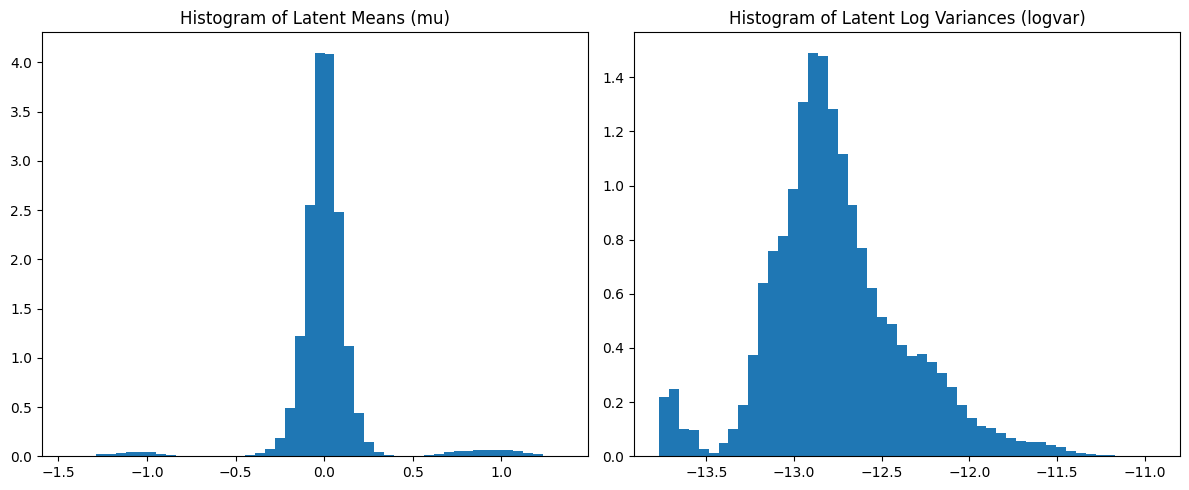

In [10]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# stage3 = '/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30_datasampler/stage3/best_joint.pth'
# model3 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

In [11]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim=(10,10), cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

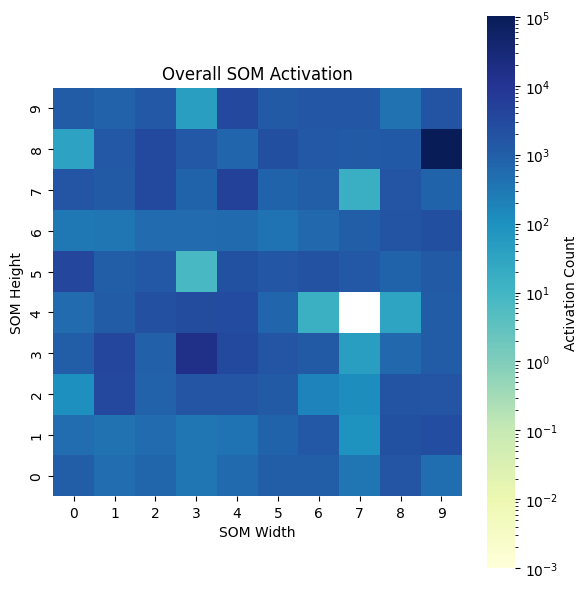

In [12]:
activation_map = compute_som_activation_heatmap(model3,test_loader, device)
plot_som_activation_heatmap(activation_map)

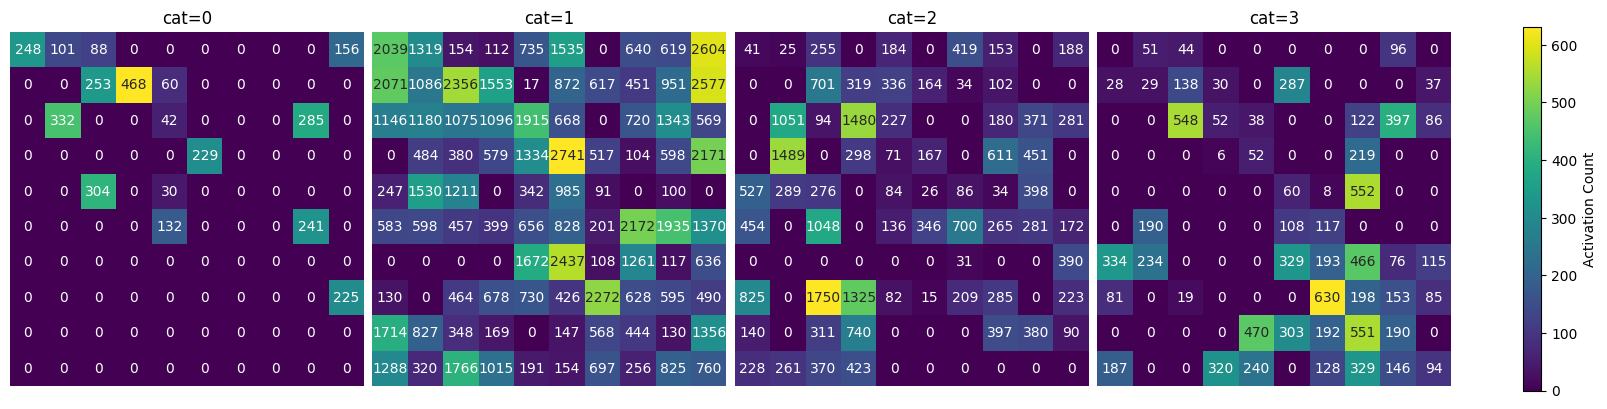

In [25]:

som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

In [13]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_som_avg_category(heatmap, som_dim):
    """
    heatmap: HxW array of avg category (0,1,2,3) or NaN
    color bar:0,1,2,3
    """
    import numpy as np
    H, W = som_dim

    cmap = plt.get_cmap("YlGnBu", 4)
    # boundaries: [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(np.arange(-0.5, 4), ncolors=cmap.N, clip=True)

    plt.figure(figsize=(W*0.6, H*0.6))
    ax = sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=norm,
        annot=True,
        fmt=".0f",
        square=True,
        linewidths=.5,
        linecolor="gray",
        cbar_kws={
            "ticks": np.arange(4),          
            "boundaries": np.arange(-0.5,4),
            "spacing": "proportional",      
            "label": "Risk Level"
        }
    )

    # 强制 colorbar 仅显示整数标签
    cbar = ax.collections[0].colorbar
    cbar.set_ticklabels([str(i) for i in range(4)])

    plt.title("SOM Node for Risk Level")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

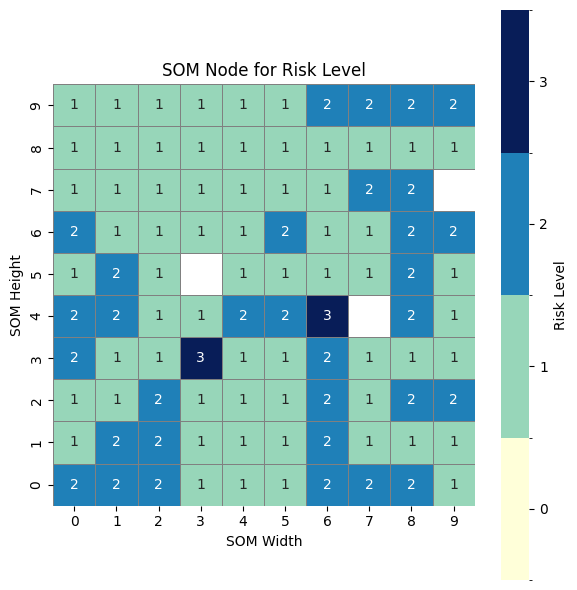

In [14]:

som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)